## CNN 모델 네트워크 구축

In [1]:
import numpy as np
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

### 데이터 불러오기

In [3]:
NUMPY_ROOT_PATH = 'C:/Users/PC00/Desktop/24하계 연수생/Handwriting_Classification/Numpy_data/'

In [4]:
X = np.load(NUMPY_ROOT_PATH+'20s_3_X.npy')
X = torch.tensor(X.reshape(-1, X.shape[3], X.shape[1], X.shape[2]), dtype=torch.float32)

In [5]:
y = np.load(NUMPY_ROOT_PATH+'20s_3_y.npy')
y = torch.tensor(y.reshape(-1), dtype=torch.long)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [8]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

torch.Size([76144, 1, 76, 180]) torch.Size([9518, 1, 76, 180]) torch.Size([9518, 1, 76, 180])
torch.Size([76144]) torch.Size([9518]) torch.Size([9518])


### 모델 생성

In [9]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Dropout2d(0.25)
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*6*18, 128),
            nn.ReLU(),

            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(-1, 64*6*18)
        out = self.fc_layer(out)

        return out

model = LeNet().to(device)
print(model)

LeNet(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6912, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


In [11]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCH = 200

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
train_loss, valid_loss, train_acc, valid_acc = [], [], [], []

for i in range(50):
    model.train()

    train_total_loss, train_correct, cnt = 0, 0, 0

    for j in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train[j:j+BATCH_SIZE].to(device)
        y_batch = y_train[j:j+BATCH_SIZE].to(device)

        optimizer.zero_grad()
        output = model(X_batch)

        loss = loss_func(output, y_batch)

        train_total_loss += loss.item()
        train_correct += (output.argmax(1) == y_batch).int().sum()
        cnt += 1

        loss.backward()
        optimizer.step()
    
    train_loss.append(train_total_loss / cnt)
    train_acc.append(train_correct.to('cpu') / len(X_train))

    model.eval()
    with torch.no_grad():
        y_pred = model(X_valid.to(device))
        loss = loss_func(y_pred, y_valid.to(device))

        valid_loss.append(loss.item())
        valid_acc.append((y_pred.argmax(1) == y_valid.to(device)).float().mean().item())

    print(f'Epoch: {i+1:03d}/{EPOCH} | Train Loss: {train_loss[-1]:.5f} | Valid Loss: {valid_loss[-1]:.5f} | Train Acc: {train_acc[-1]:.5f} | Valid Acc: {valid_acc[-1]:.5f}')

Epoch: 001/200 | Train Loss: 0.65730 | Valid Loss: 0.62514 | Train Acc: 0.60435 | Valid Acc: 0.65360
Epoch: 002/200 | Train Loss: 0.62239 | Valid Loss: 0.60097 | Train Acc: 0.65090 | Valid Acc: 0.67672
Epoch: 003/200 | Train Loss: 0.60649 | Valid Loss: 0.58961 | Train Acc: 0.66679 | Valid Acc: 0.68954
Epoch: 004/200 | Train Loss: 0.59698 | Valid Loss: 0.58318 | Train Acc: 0.68080 | Valid Acc: 0.69973
Epoch: 005/200 | Train Loss: 0.59018 | Valid Loss: 0.57851 | Train Acc: 0.68762 | Valid Acc: 0.70435
Epoch: 006/200 | Train Loss: 0.58279 | Valid Loss: 0.57227 | Train Acc: 0.69807 | Valid Acc: 0.71202
Epoch: 007/200 | Train Loss: 0.57770 | Valid Loss: 0.56852 | Train Acc: 0.70539 | Valid Acc: 0.71801
Epoch: 008/200 | Train Loss: 0.57365 | Valid Loss: 0.56691 | Train Acc: 0.71081 | Valid Acc: 0.71748
Epoch: 009/200 | Train Loss: 0.56954 | Valid Loss: 0.56965 | Train Acc: 0.71648 | Valid Acc: 0.70740
Epoch: 010/200 | Train Loss: 0.56205 | Valid Loss: 0.56384 | Train Acc: 0.72670 | Valid Acc

### loss, accuracy 그래프

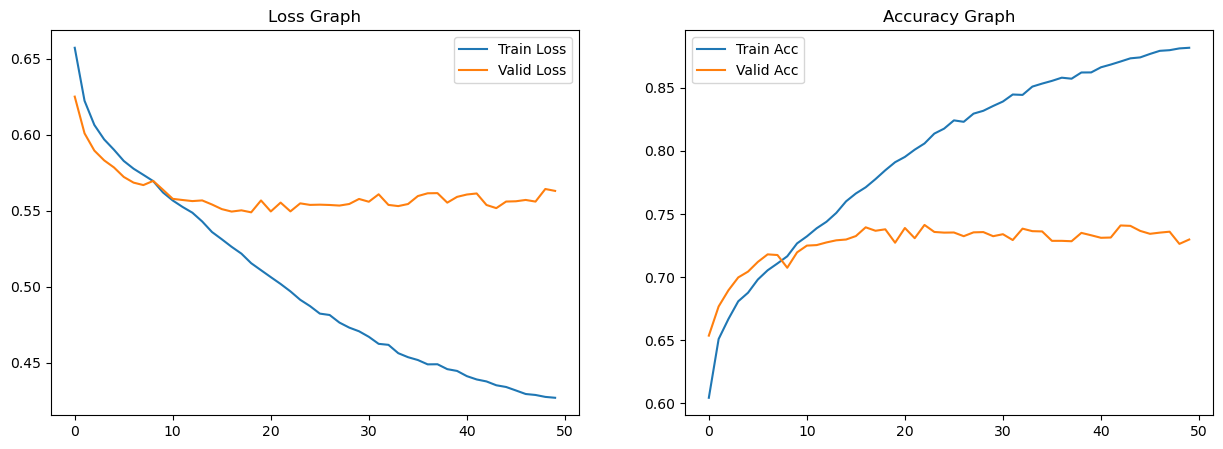

In [14]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(valid_loss, label='Valid Loss')
ax[0].set_title('Loss Graph')
ax[0].legend()

ax[1].plot(train_acc, label='Train Acc')
ax[1].plot(valid_acc, label='Valid Acc')
ax[1].set_title('Accuracy Graph')
ax[1].legend()

plt.show()